In [ ]:
import pandas as pd
newsela_align = pd.read_csv('data/newsela_data_share-20150302/newsela_articles_20150302.aligned.sents.txt', sep='\t', names=['DOC', 'V_normal', 'V_simple', 'normal_phrase', 'simple_phrase'], on_bad_lines='skip').dropna()
newsela_align

In [ ]:
newsela_align = newsela_align.groupby(['V_normal','V_simple', 'DOC', 'normal_phrase']).agg(tuple).applymap(list).reset_index()
newsela_align['simple_phrase'] = newsela_align['simple_phrase'].apply(lambda x: ' '.join(x))
newsela_align = newsela_align[newsela_align.V_normal == 'V0']
newsela_align

In [19]:
newsela_align.to_csv('data/newsela_sent_aligned_V0.csv', index=False)

In [ ]:
from tqdm import tqdm

newsela_new = pd.DataFrame([])

def append_row_to_df(filtered, normal_phrase):
    global newsela_new
    for _, line in filtered.iterrows():
        if len(newsela_new[newsela_new.simple_phrase == line.simple_phrase]) >= 0:
            continue
        line_tmp = line.copy()
        line_tmp['V_normal'] = "V0"
        line_tmp['normal_phrase'] = normal_phrase
        newsela_new = pd.concat([newsela_new, pd.DataFrame([line_tmp])], ignore_index=True)
        f_new = newsela_align[newsela_align.normal_phrase == line_tmp.simple_phrase].copy()
        append_row_to_df(f_new, normal_phrase)

for i, row in tqdm(newsela_align.iterrows(), total=len(newsela_align)):
    if row.V_normal == "V0":
        newsela_new = pd.concat([newsela_new, pd.DataFrame([row])], ignore_index=True)
        new_pair = newsela_align[newsela_align.normal_phrase == row.simple_phrase].copy()
        if len(new_pair) > 0:
            append_row_to_df(new_pair, row.normal_phrase)
newsela_new

In [15]:
newsela_new.to_csv('data/newsela_sent_aligned_merged.csv', index=False)

## Reduced tasks

In [ ]:
import pandas as pd

#newsela_path = "../../Datasets_local/Newsela/"
newsela_path = "data/"
aligned_combined = pd.read_csv(newsela_path + 'newsela_sent_aligned_V0_pred.csv')
aligned_combined

In [ ]:
#label_mapping = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5, '1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5, 1.0: 1, 0.0: 0}
label_mapping = {'anger': 'negative', 'disgust': 'negative', 'fear': 'negative', 'joy': 'positive', 'sadness': 'negative', 'surprise': 'negative', 'neutral': 'neutral'}
aligned_combined = aligned_combined.replace(label_mapping)
aligned_combined

## Levenstein vs. misclassification rate

In [ ]:
import pandas as pd

aligned_combined = pd.read_csv("data/newsela_sent_aligned_V0_pred.csv")
#aligned_combined = pd.read_csv("data/newsela_sent_aligned_all_new.csv")
aligned_combined

In [27]:
from tqdm import tqdm
from Levenshtein import distance, ratio

colors = {
    'emotion': '#377eb8', 'fake_news': '#ff7f00', 'topic': '#4daf4a', 'sentiment_2': '#f781bf',
    #'emotion': '#377eb8', 'fake_news_2': '#ff7f00', 'topic_ag': '#4daf4a', 'sentiment_news_2': '#f781bf',
}

#aligned_combined = aligned_combined[aligned_combined.V_simple.isin(['V1', 'V2', 'V3', 'V4'])]
#aligned_combined = aligned_combined[aligned_combined.V_simple == 'V4']
distances = []
num_errors = []

for _, row in tqdm(aligned_combined.iterrows(), total=len(aligned_combined)):
    errors = 0
    for task in colors.keys():
        if row[task + '_normal'] != row[task + '_simple']:
            errors += 1
    num_errors.append(errors)
    distances.append(distance(row.normal_phrase, row.simple_phrase)/len(row.normal_phrase))#, score_cutoff=100))
    #distances.append(distance(row.normal_phrase, row.simple_phrase, processor=lambda s: s.split(' ')))#, score_cutoff=100))
    #distances.append(ratio(row.normal_phrase, row.simple_phrase))

aligned_combined['distance'] = distances
aligned_combined['num_errors'] = num_errors

100%|██████████| 61376/61376 [00:07<00:00, 8078.63it/s]


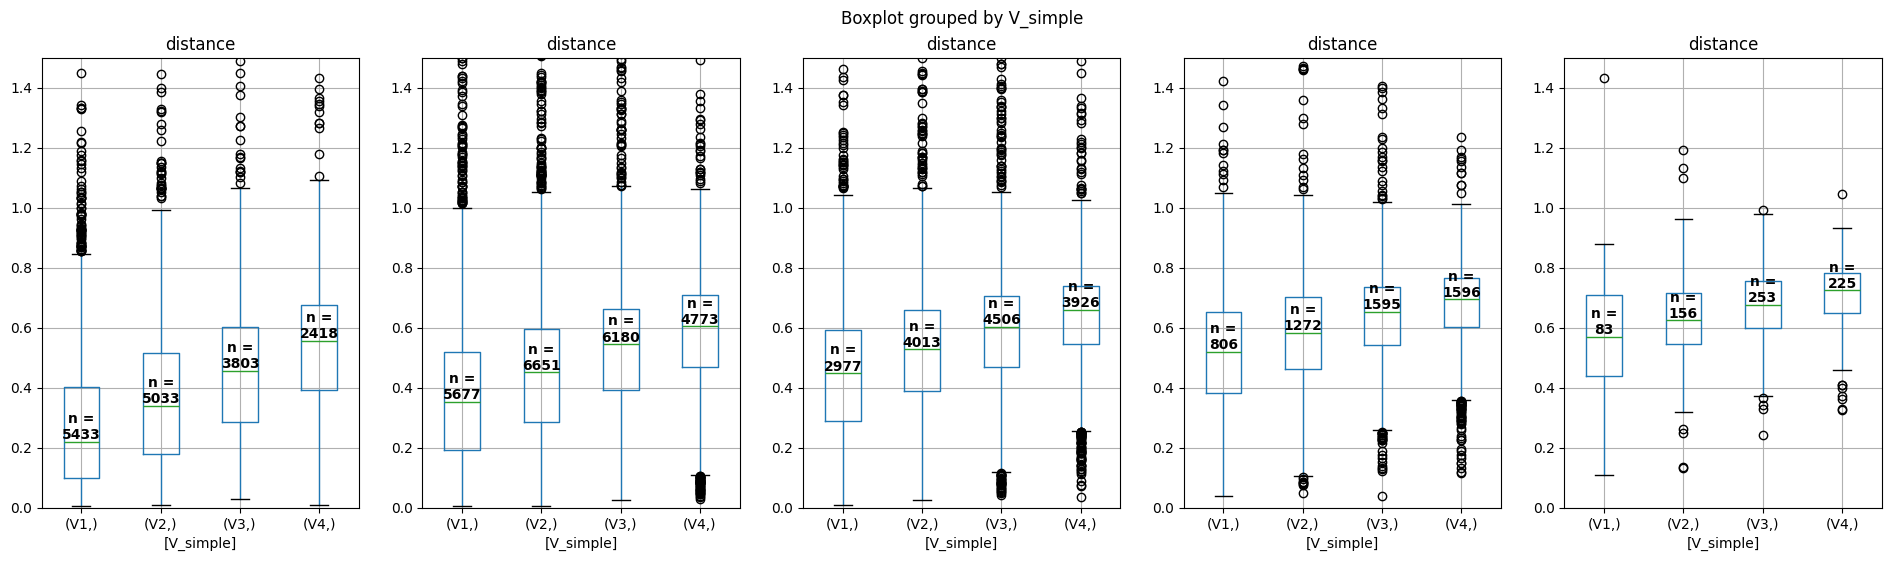

In [28]:
import matplotlib.pyplot as plt

versions = ['V1', 'V2', 'V3', 'V4']#, 'Vp', 'Vs']
aligned_combined_orig = aligned_combined[aligned_combined.V_simple.isin(versions)]

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(23,6))
for ax, error in zip(axs, range(5)): # num_errors ranges between 0 and 4
    ax.set_title(error)
    ax.set_ylim([0,1.5])
    n_observations = aligned_combined_orig[aligned_combined_orig.num_errors == error].value_counts('V_simple').to_dict()
    
    medians = aligned_combined_orig[aligned_combined_orig.num_errors == error].groupby(['V_simple'])['distance'].median().values

    for i in range(len(versions)):
        ax.text(i +1, medians[i] + 0.01, f"n =\n{n_observations[versions[i]]}", horizontalalignment='center', weight='semibold')
        
    aligned_combined_orig[aligned_combined_orig.num_errors == error].boxplot(column=['distance'], by=['V_simple'], ax=ax)
plt.show()

Text(0, 0.5, 'Levenshtein distance')

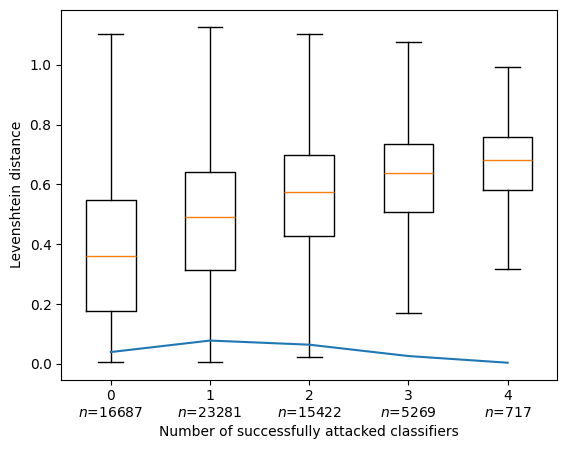

In [29]:
import numpy as np
import matplotlib.pyplot as plt
dists_en = {
    0: np.array(distances)[np.array(num_errors) == 0].tolist(),
    1: np.array(distances)[np.array(num_errors) == 1].tolist(),
    2: np.array(distances)[np.array(num_errors) == 2].tolist(),
    3: np.array(distances)[np.array(num_errors) == 3].tolist(),
    4: np.array(distances)[np.array(num_errors) == 4].tolist(),
}

fig, ax = plt.subplots()
ax.boxplot(dists_en.values(), showfliers=False)
ax.set_xticklabels([f"{k}\n$n$={len(dists_en[k])}" for k in dists_en.keys()])
num_samples = len(aligned_combined_orig)
perc_level_4 = [len(aligned_combined_orig[(aligned_combined_orig.num_errors == e) & (aligned_combined_orig.V_simple=='V4')])/num_samples for e in range(5)]
plt.plot(range(1,6), perc_level_4)
plt.xlabel("Number of successfully attacked classifiers")
plt.ylabel("Levenshtein distance")

In [53]:
aligned_combined.to_csv("data/newsela_sent_aligned_V0_pred.csv", index=False)

In [30]:
import json
with open('lev_dist_german.json', 'r') as fp:
    dists_de = json.load(fp)
with open('lev_dist_italian.json', 'r') as fp:
    dists_it = json.load(fp)

    distance  num_errors     lang
0   0.152174           0  English
1   0.383562           0  English
2   0.145455           0  English
3   0.396552           0  English
4   0.171329           0  English
..       ...         ...      ...
11  0.055556           3  Italian
12  0.545455           3  Italian
13  0.547619           3  Italian
14  0.092233           3  Italian
15  0.311927           3  Italian

[66516 rows x 3 columns]


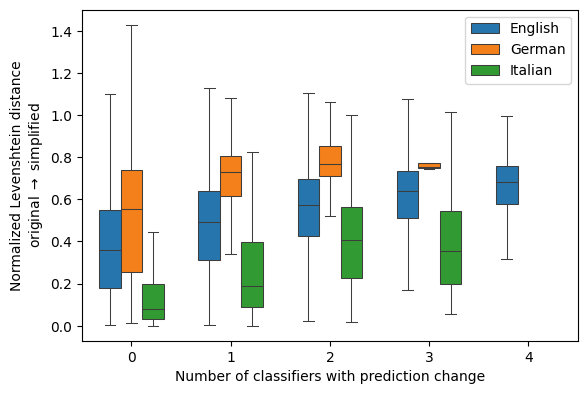

In [33]:
import pandas as pd
import seaborn as sns
plt.figure(figsize=(6.4, 4.3))

en = pd.concat([pd.DataFrame({'distance':d, 'num_errors': int(n), 'lang': "English"}) for n, d in dists_en.items()])
de = pd.concat([pd.DataFrame({'distance':d, 'num_errors': int(n), 'lang': "German"}) for n, d in dists_de.items()])
it = pd.concat([pd.DataFrame({'distance':d, 'num_errors': int(n), 'lang': "Italian"}) for n, d in dists_it.items()])

cdf = pd.concat([en, de, it])
print(cdf)# CONCATENATE
mdf = pd.melt(cdf, id_vars=['distance'], var_name=['num_errors'])

#ax = sns.boxplot(x="num_errors", y="value", hue="distance", data=cdf)  # RUN PLOT
ax = sns.boxplot(data=cdf, x="num_errors", y="distance", hue="lang", showfliers=False, saturation=.9, width=.65, linewidth=.75)  # RUN PLOT
plt.xlabel("Number of classifiers with prediction change")
plt.ylabel("Normalized Levenshtein distance\noriginal $\\rightarrow$ simplified")
plt.legend(loc="upper right")
#plt.show()
plt.savefig("plots/lev_distances.pdf")

#plt.clf()
#plt.close()

In [32]:
from scipy.stats import spearmanr, pearsonr

print(spearmanr(en['distance'], en['num_errors']))
print(spearmanr(de['distance'], de['num_errors']))
print(spearmanr(it['distance'], it['num_errors']))

SignificanceResult(statistic=0.3535099445488469, pvalue=0.0)
SignificanceResult(statistic=0.3591135084456738, pvalue=8.579123113838829e-65)
SignificanceResult(statistic=0.3439489222159083, pvalue=2.677421913031858e-85)


## Label distribution

0.5747963017689027
0.0
0.6443365559167475
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.37070122852197407
0.0
0.45875796850593153


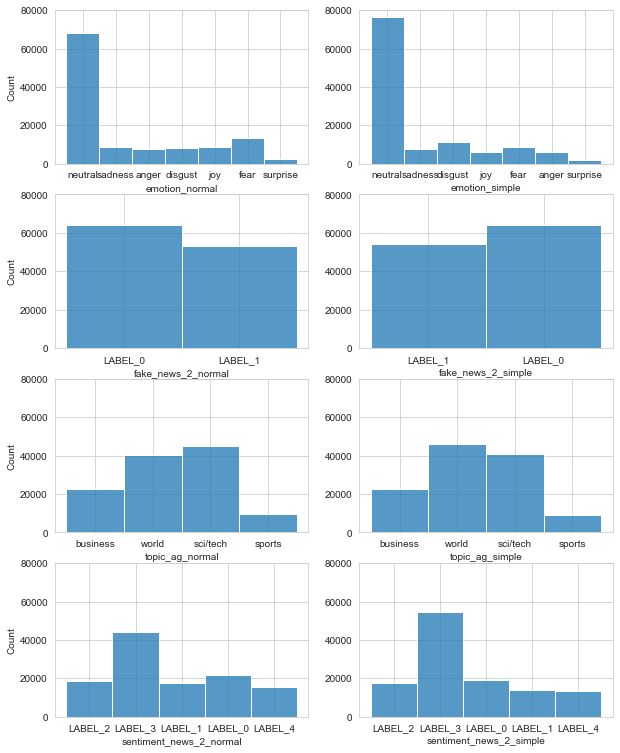

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(10, 13))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        col.set_ylim([0, 80000])
        sns.histplot(data=aligned_combined[task + identifier],discrete=True, ax=col)  # RUN PLOT
        print(len(aligned_combined[aligned_combined[task + identifier] == 'neutral'])/len(aligned_combined))
        print(len(aligned_combined[aligned_combined[task + identifier] == 'LABEL_3'])/len(aligned_combined))
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()